In [18]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display
import pandas as pd

from tqdm import tqdm

In [19]:
data = pd.read_pickle('data.pkl')

In [20]:
print('ratio of trains that show defects: ',end='')
print(sum(data['target_vector'].apply(np.sum) > 0), 'of', len(data))

ratio of trains that show defects: 24 of 35


overall duration of target sound in seconds 80.6


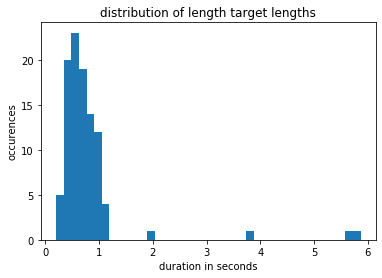

In [21]:
defect_duration_lists = data['durations_in_s'].tolist()
defect_durations = [val for sublist in defect_duration_lists for val in sublist]
defect_durations = [dur for dur in defect_durations if dur != 0.0]
print(f'overall duration of target sound in seconds {sum(defect_durations):.1f}')

counts, bins, _ = plt.hist(defect_durations, 40)
plt.title('distribution of length target lengths');
plt.xlabel('duration in seconds'); plt.ylabel('occurences');

In [23]:
frame_len = 8000
total_len = np.hstack(data['audio_content'].tolist()).shape[0]
print(f'overall duration of dataset in minutes {total_len/8000/60:.2f}')
print(f'ratio of anomalous to normal audio {sum(defect_durations)/(total_len/8000):.2%}')

overall duration of dataset in minutes 23.37
ratio of anomalous to normal audio 5.75%


# Slice Dataset

In [27]:
frame_length = 12000

# extract slices
X = data['audio_content'].apply(librosa.util.frame, 
                                frame_length=frame_length, 
                                hop_length=frame_length)
X = X.apply(np.transpose)
y = data['target_vector'].apply(librosa.util.frame, 
                                frame_length=frame_length,
                                hop_length=frame_length)
y = y.apply(np.transpose)

# collect in data frame
sliced = pd.DataFrame()
sliced['X'] = X.explode()
sliced['y'] = y.explode()

sliced.index.rename('file_number', inplace=True)
sliced.reset_index(inplace=True)

In [28]:
# slices with non zero target
print('anomalous slices:',
      len(sliced['y'][sliced['y'].apply(np.sum) > 1600]),
      '\nof total slices:',
      len(sliced['y']))

anomalous slices: 115 
of total slices: 918


In [29]:
def sum_threshold(x, threshold=1600):
    x = np.sum(x) > threshold
    return float(x)
    
sliced['y'] = sliced['y'].apply(sum_threshold)

In [30]:
anomalous_sample_idx = sliced.index[sliced['y']!=0].tolist()

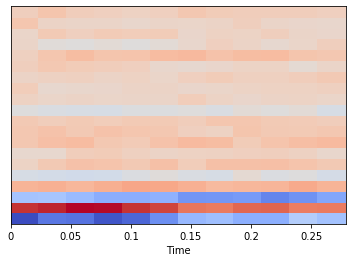

In [32]:
samp = sliced['X'][anomalous_sample_idx[1]]
sampfcc = librosa.feature.mfcc(y=samp, sr=8000, hop_length=1024, htk=True)
librosa.display.specshow(sampfcc, x_axis='time')
import IPython.display as ipd
ipd.Audio(samp, rate=8000)

In [33]:
def mfccify(x):
    xmfcc = librosa.feature.mfcc(y=x,sr=8000,
                                hop_length=1024, 
                                htk=True).flatten()
    return xmfcc
sliced['X'] = sliced['X'].apply(mfccify)

X = np.zeros([sliced['X'].shape[0], sliced['X'][0].shape[0]])
for idx, data in enumerate(sliced['X']):
    X[idx,:] = data

y = sliced['y'].to_numpy()

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import confusion_matrix
svc = SVC(C=10, gamma=0.00001, kernel='rbf', tol=0.01, class_weight='balanced')
cv_results = cross_validate(svc, X, y, cv=3,
                            scoring=('roc_auc'),
                            n_jobs=-1)

sorted(cv_results.keys()), cv_results['test_score']

(['fit_time', 'score_time', 'test_score'],
 array([0.79066207, 0.80096229, 0.79183915]))

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# setup parameter grid
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)

# setup inner CV loops
inner_cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
outer_cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

# setup nested CV
svc = SVC('rbf', class_weight='balanced', probability=True)
clf = GridSearchCV(estimator=svc, param_grid=param_grid, iid=False,
                    cv=inner_cv, scoring='roc_auc', verbose=1, n_jobs=-1)
scores = cross_validate(clf, X=X, y=y, cv=outer_cv, return_estimator=True,
                         scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ................................................................
Fitting 3 folds for each of 169 candidates, totalling 507 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:  1.4min finished


[CV] .................................... , score=0.867, total= 1.4min
[CV]  ................................................................
Fitting 3 folds for each of 169 candidates, totalling 507 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:  1.5min finished


[CV] .................................... , score=0.915, total= 1.5min
[CV]  ................................................................
Fitting 3 folds for each of 169 candidates, totalling 507 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 507 out of 507 | elapsed:  1.6min finished


[CV] .................................... , score=0.829, total= 1.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min finished


In [120]:
import joblib
joblib.dump(scores, 'grid_searched_svc.joblib')

['grid_searched_svc.joblib']

In [121]:
scores['test_score']

array([0.88977424, 0.91987605, 0.91264571])

In [122]:
from sklearn.metrics import roc_auc_score

In [124]:
# on whole data set
[roc_auc_score(y,scores['estimator'][i].predict(X)) for i in range(3)]

[0.8713117647058823, 0.8844176470588235, 0.9252705882352943]

In [125]:
[scores['estimator'][i].best_params_ for i in range(3)]

[{'C': 10.0, 'gamma': 1e-06},
 {'C': 10.0, 'gamma': 1e-06},
 {'C': 10.0, 'gamma': 0.0001}]

In [128]:
from sklearn.metrics import confusion_matrix
confs = [confusion_matrix(y,scores['estimator'][i].predict(X)) for i in range(3)]

In [130]:
[print(confs[i],'\n') for i in range(3)];

[[1011  239]
 [   9  127]] 

[[1007  243]
 [   5  131]] 

[[1247    3]
 [  20  116]] 



In [ ]:
# should we add calibration?
# https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV
# reminder on how to handle imbalanced data
# https://elitedatascience.com/imbalanced-classes

In [ ]:
# TSNE?